# Assignment 7.2

## Lincoln Brown

## DSC530-T301
## Dr. Parjajulee

In [65]:
import thinkstats2
import thinkplot
import first
import random
from scipy.stats import binom_test

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values




In [80]:
# I wanted to better understand how to implement these kinds of tests, so I looked up how to do a coin test
# without using the example in the book
#Coin Test
#binom_test(x, n=None, p=0.5, alternative='two sided')
"""
Where 
x: number of successes 
n: total number of trials
p: the probability of success on each trial
alternative: the alternative hypothesis, default is two-sided but you can also use greater or less

"""

#Example of coin flip
#What are the chances of getting 140 out of 250 flips to land on heads?
# x = 140, n = 250, p=0.5
x = 140
n = 250
p = 0.5
coin_flip = binom_test(x=x, n=n, p=p)
print(f"The chances of landing on heads {x} out of {n} times is: {coin_flip}")

The chances of landing on heads 140 out of 250 times is: 0.06642115124004333


In [81]:
class CoinTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat
    
    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data
    
ct = CoinTest((140, 110))
pvalue = ct.PValue()

print(pvalue)

# I believe the discrepancies in the p-value between the two functions is due to the randomized nature
# of the thinkstats test. 

0.06


In [83]:
from sklearn.datasets import load_iris
import numpy as np

iris = load_iris()
X = iris.data
y = iris.target

n_uncorrelated_features = 2200
rng = np.random.RandomState(seed=0)

#Use same number of samples as in iris and 2200 features
X_rand = rng.normal(size=(X.shape[0], n_uncorrelated_features))

In [84]:
# Permutation testing using sklearn

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from scipy import stats

clf = SVC(kernel='linear', random_state=7)
cv = StratifiedKFold(2, shuffle=True, random_state=0)

score_iris, perm_scores_iris, pvalue_iris = permutation_test_score(
    clf, X, y, scoring="accuracy", cv=cv, n_permutations=1000)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, y, scoring="accuracy", cv=cv, n_permutations=1000)



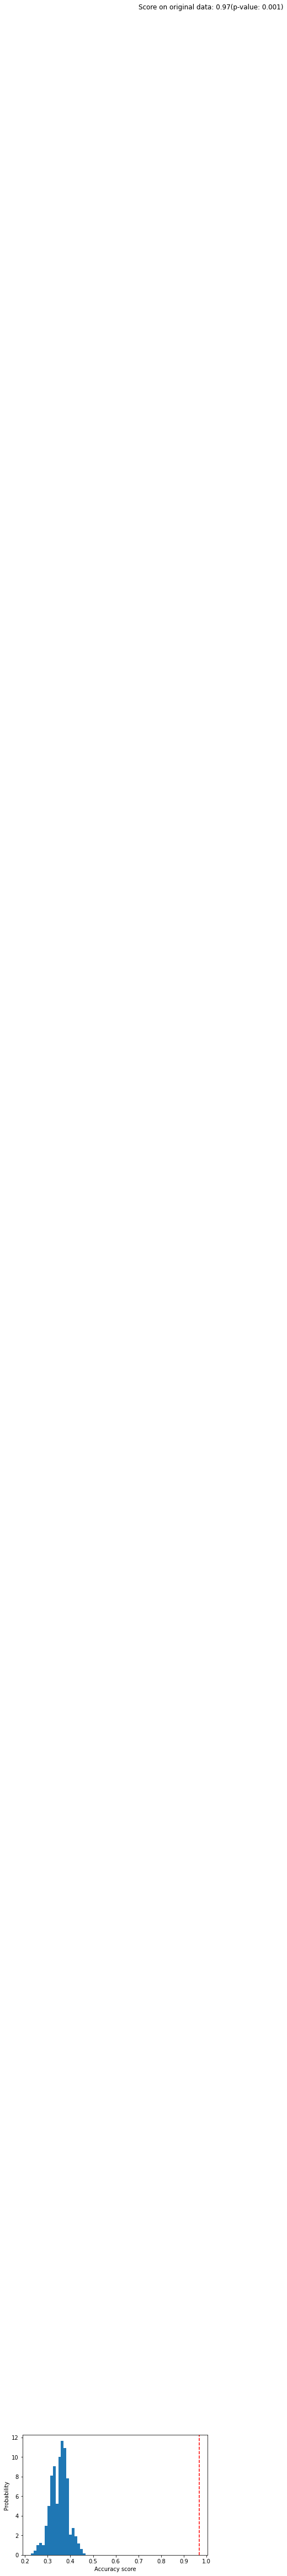

In [88]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(perm_scores_iris, bins=20, density=True)
ax.axvline(score_iris, ls='--', color='r')
score_label = (f"Score on original data: {score_iris:.2f}"
              f"(p-value: {pvalue_iris:.3f})")
ax.text(0.7, 260, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")


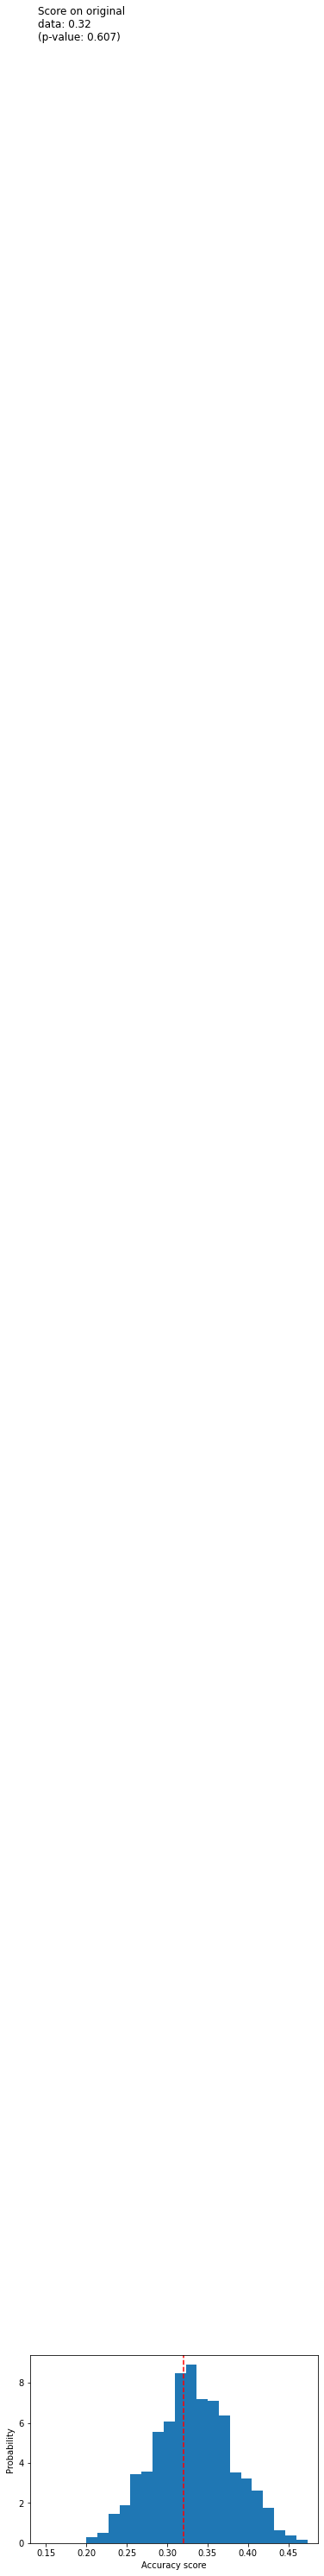

In [131]:
fig, ax = plt.subplots()

ax.hist(perm_scores_rand, bins=20, density=True)
ax.set_xlim(0.13)
ax.axvline(score_rand, ls='--', color='r')
score_label = (f"Score on original\ndata: {score_rand:.2f}\n"
               f"(p-value: {pvalue_rand:.3f})")
ax.text(0.14, 125, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")
plt.show()

In [87]:
lcv = stats.norm.ppf(.025)
print(f"Lower Critical Value: {round(lcv,3)}")
ucv = stats.norm.ppf(1-.025)
print(f"Upper Critical Value: {round(ucv,3)}")

n = len(live)
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

data1 = firsts.prglngth.values
data2 = others.prglngth.values


se = np.sqrt( np.std(data1)**2 / len(data1) + np.std(data2)**2 / len(data2))
print(f"Standard error: {round(se,3)}")

emp_diff_means = np.mean(data1) - np.mean(data2)
print(f"Empirical difference of means: {round(emp_diff_means,3)}")



Lower Critical Value: -1.96
Upper Critical Value: 1.96
Standard error: 0.057
Empirical difference of means: 0.078


In [99]:
class DiffMeansPermute(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat
    
    def MakeModel(self):
        group1, group2 = self.data
        
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))
        
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
 

In [94]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys


In [95]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [97]:
# This function accepts a dataframe and a number of iterations. 
# Each of the functions create permutations of the data
# Pooling the firsts and others data
# Subsequent samples are taken from the pool
# to create a distribution of the test statistics

def RunTests(live, iters=1000):
    """Runs the tests from Chapter 9 with a subset of the data.

    live: DataFrame
    iters: how many iterations to run
    """
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    # compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))

In [100]:
# Start with the length of the live dataset and divide it by two each iteration for seven iterations.
# The sample rows are taken from live with a length of n each time. This creates shrinking sample sizes.
n = len(live)
print("n\ttest1 \ttest2\ttest3\ttest4")
for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)
    n //= 2

n	test1 	test2	test3	test4
9148	0.17	0.00	0.00	0.00
4574	0.36	0.00	0.00	0.00
2287	0.13	0.04	0.00	0.38
1143	0.00	0.73	0.03	0.01
571	0.24	0.75	0.23	0.32
285	0.74	0.84	0.52	0.89
142	0.23	0.22	0.60	0.24


# Exercise 9.1

## The four additional tests run are:

Test1 = The difference in means for pregnancy lengths for first borns and others
Test2 = The difference in means for birthweight for first borns and others
Test3 = The correlation of mother's age and total weight
Test4 = Compares the chi-squared statistic for pregnancy lengths

   n	test1 	test2	test3	test4
9148	0.17	0.00	0.00	0.00
4574	0.36	0.00	0.00	0.00
2287	0.13	0.04	0.00	0.38
1143	0.00	0.73	0.03	0.01
 571	0.24	0.75	0.23	0.32
 285	0.74	0.84	0.52	0.89
 142	0.23	0.22	0.60	0.24

From these results, we can see that the p-values are very small and get larger as sample size decreases. 
The positive tests become negative as sample sizes decrease, but there is cases like test1 & test4 with n size 1143 that do not conform to expected behavior. 




In [105]:
len_firsts, len_others = len(firsts.prglngth.values), len(others.prglngth.values)
data = np.concatenate([firsts.prglngth.values, others.prglngth.values])

#Get a single permutation of the concatenated length
perm = np.random.permutation(len(firsts.prglngth.values) + len(others.prglngth.values))

# Calculate the permutated datasets and difference in means
permuted_firsts = data[perm[:len(firsts.prglngth.values)]]
permuted_others = data[perm[len(others.prglngth.values):]]
diff_in_means = permuted_firsts.mean() - permuted_others.mean()
print(f"Difference in permuted mean values {diff_in_means}")





Difference in permuted mean values 0.016768638114655232


In [130]:
reps = 1000
# Generate permutations equal to the number of repetitions
perm = np.array([np.random.permutation(len(firsts.prglngth.values) + len(others.prglngth.values)) for i in range(reps)])

permuted_firsts_ds = data[perm[: , :len(firsts.prglngth.values)]]
permuted_others_ds = data[perm[:, len(others.prglngth.values):]]

# Calculate the difference in means for each of the datasets
samples = np.mean(permuted_firsts_ds, axis=1) - np.mean(permuted_others_ds, axis=1)

test_stat = np.mean(firsts.prglngth.values) - np.mean(others.prglngth.values)
p_val = 2*np.sum(samples >= np.abs(test_stat)) /reps
print(f"p-value = {p_val}")

p-value = 0.18


In [155]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)


In [156]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)
    
    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx
    
    return inter, slope





In [157]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

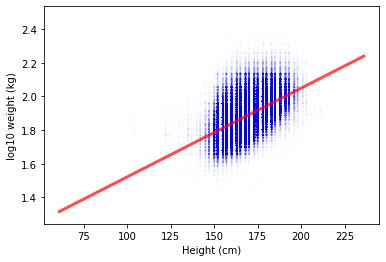

In [189]:
#Compute the linear least squares fit for log(weight) versus height.


# Here I am taking a sequence of points, ys, that I want to express as a function of sequence xs
# This means that for the weight points, I want to express them as a function of height

inter, slope = LeastSquares(heights, log_weights)

fit_xs, fit_ys = FitLine(heights, inter, slope)

thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False)



79.04441343802421
-82.65926054409954 0.9570745850332304
The average height is 168.95618848400332, the average weight is 79.04441343802421.
For every cm gained, we can expect .95 kilos in additional weight
80.00148802305743
80.00148802305742


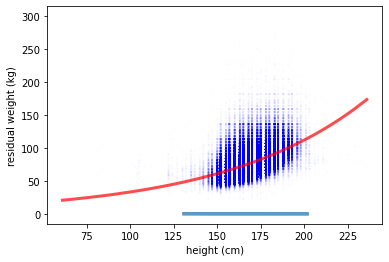

In [212]:
#Exercise 10-1

#How would you best present the estimated parameters for a model like this 
# where one of the variables is log-transformed?

# We can show the results on a linear instead of a log-transformed scale to make it more presentable

thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = FitLine(heights, inter, slope)
#We correct for the log transformation by elevating ys to the power of 10.
thinkplot.Plot(fxs, 10**fys, color='red')
thinkplot.Config(xlabel='Height (cm)', yabel='Weight (kg)', legend=False)

#If you were trying to guess someone's weight, how much would it help to know their height?

# It is very helpful, the weight can be predicted fairly well, as demonstrated below
inter1, slope1 = LeastSquares(heights, weights)
h_mean = np.mean(heights)
w_mean = np.mean(weights)

print(h_mean * slope1 + inter1)
print(inter1, slope1)
print(f"The average height is {h_mean}, the average weight is {w_mean}.")
print(f"For every cm gained, we can expect .95 kilos in additional weight")
#Add one cm to the mean and confirm it matches the value of the mean weights plus the slope
test = (h_mean + 1) * slope1 + inter1
#Mean weight + slope1 should equal weight defined in test variable
print(w_mean + slope1)
print(test)


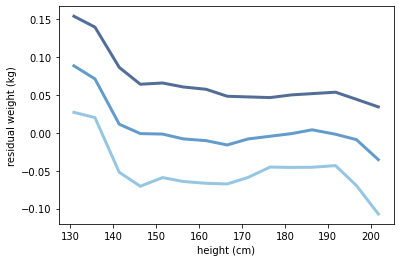

In [213]:
#Now it is important to look at this relationship by percentile to make sure it is reliable across the range

res = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups] [1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend = False)

#Plotting the residual allows us to see the difference in variance by looking at how parallel the lines are.
#The lines are mostly parallel, indicating a constant residual variance across the range.
# The lines are also generally flat, indicating a linear relationship. 

In [217]:
# Find the correlation
rho = thinkstats2.Corr(heights, log_weights)
#rho = p
#R^2 = p^2 
print(rho)
r2 = thinkstats2.CoefDetermination(log_weights, res)
print(r2)

print(rho**2 - r2)

0.5317282605983439
0.28273494311893743
2.886579864025407e-15


In [218]:
#MSE without the model
std_ys = thinkstats2.Std(log_weights)
print(std_ys)

0.10320725030004871


In [219]:
# Root Mean Squared Error
std_res = thinkstats2.Std(res)
print(std_res)

0.08740777080416084


In [222]:
#The ratio of std_res / std_ys is the fraction of MSE that remains if you use the model
# R^2 is the fraction of MSE the model eliminates
# How much does having the height reduce RMSE?
reduce = 1 - std_res / std_ys
print(reduce)

0.15308497658793263


In [243]:
#Use resampling with and without weights, to estimate the mean height of responsdents in the BRFSS,
# the standard error of the mean, and a 90% confidence interval. 

# How much does correct weighting affect the estimates?
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print(f"The mean is: {mean}")
    print(f"The Standard Error is: {stderr}")
    print(f"The confidence interval is: {ci}")


def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample


t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)



{'xscale': 'linear', 'yscale': 'linear'}

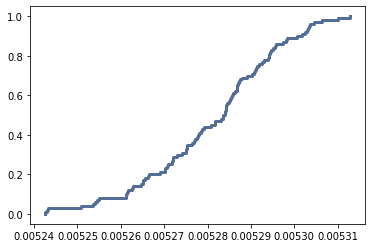

In [227]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

In [241]:
#Calculate the pvalue and 90% confidence interval of the slope.
pvalue = cdf[0]
print(f"The pvalue of the slope is: {pvalue}")
ci = cdf.ConfidenceInterval(90)
print(f"The 90% confidence interval of the slope is {ci}")



The pvalue of the slope is: 0.0
The 90% confidence interval of the slope is (0.005253468978220488, 0.005303453668652842)


In [235]:
mean = thinkstats2.Mean(slopes)
print(f"The mean of the sampling distribution is {mean}")

stderr = thinkstats2.Std(slopes)
print(f"The standard error of the sampling distribution is {stderr}")

The mean of the sampling distribution is 0.005280951795935404
The standard error of the sampling distribution is 1.523318434084656e-05


In [245]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

The mean is: 168.95547398896503
The Standard Error is: 0.018598512991163132
The confidence interval is: (168.92492269447644, 168.9842761575618)


In [247]:
estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

The mean is: 170.50036869176824
The Standard Error is: 0.01666287356184866
The confidence interval is: (170.47591402413144, 170.52667040562662)


In [ ]:
# The weighted estimates have a mean height that is nearly 2cm taller
# This difference is much larger than the sampling error. 